## Exercise 1.4 Hotdog -- no hotdog : Transfer learning

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from torchinfo import summary

from typing import Dict, List, Tuple

In [2]:
torch.cuda.empty_cache()

We always check that we are running on a GPU

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../data/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

## Transfer Learning: EfficientNet

### Load Data

In [4]:
# Define helper functions
def plot_pictures(loader: DataLoader, quantity: int):
  images, labels = next(iter(loader))
  plt.figure(figsize=(20,10))

  for i in range(quantity):
      plt.subplot(5,7,i+1)
      plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
      plt.title(['hotdog', 'not hotdog'][labels[i].item()])
      plt.axis('off')

Perform data transform to dataset as in EfficientNetV1 model:
- Resize (128, 128)
- To Tensor (0,1)
- Mean and std normalization


In [5]:
# Define paramenter for tranformer
size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transformer
# Define transformer
train_transformer = transforms.Compose([transforms.Resize((size, size)),
                                        transforms.RandomRotation(10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean,
                                                             std=std)])

test_transformer = transforms.Compose([transforms.Resize((size, size)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean,
                                                            std=std)])
# Create train and test dataloaders
batch_size = 64
num_workers = os.cpu_count()  # detects number of CPUs
print(f'Number of cores available: {num_workers}')
trainset = Hotdog_NotHotdog(train=True, transform=train_transformer)# Train
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=min(2, num_workers))
testset = Hotdog_NotHotdog(train=False, transform=test_transformer)# Test
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=min(2, num_workers))
# Verify data size
print(f'Size of train dataset: {len(trainset)}, size of test dataset: {len(test_loader)}')

Number of cores available: 8
Size of train dataset: 2047, size of test dataset: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4110641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Cl

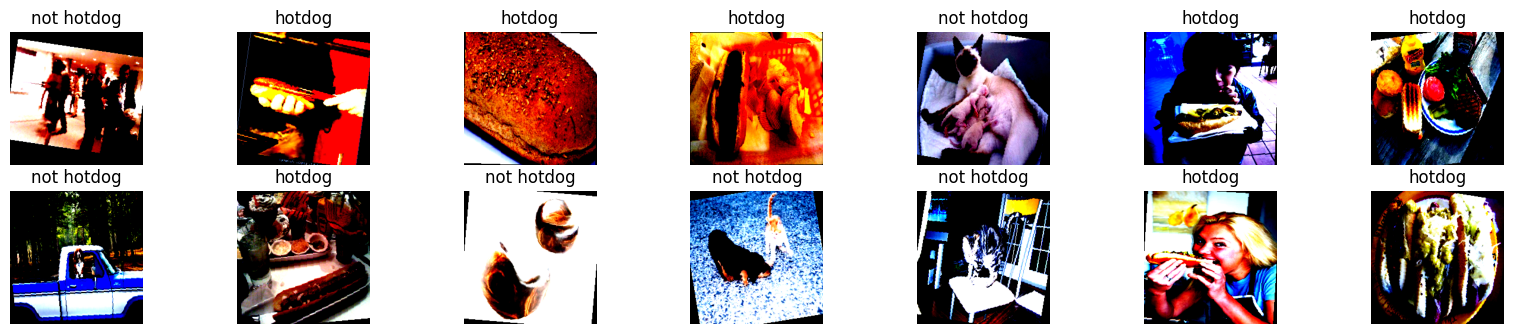

In [14]:
# Plot input pictures
plot_pictures(train_loader, 14)

### Set up pretrained model

In [67]:
# Set up weights
weights = models.EfficientNet_B7_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
model = models.efficientnet_b7(weights=weights).to(device)

Efficientnet_b7 comes in three main parts:

- features - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").
- avgpool - Takes the average of the output of the features layer(s) and turns it into a feature vector.
- classifier - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

In [68]:
# Get a summary of EfficientNet model
torch.cuda.empty_cache()
summary(model=model,
        input_size=(32, 3, size, size),
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 2560, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 64, 112, 112]   1,728                True
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    │    └─SiLU (2)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 64, 112, 112]   [32, 32, 112

Now, we are going to freeze some base layers of the pretrained model and adjust the output layers (Classifier layer)

In [69]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [70]:
# Adapt the classifier layers
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = 2 # HotDog and NotHotDog
num_features = (model.classifier[-1].in_features)

print(f"Adapting model...")
print(f"Num. of classes: {output_shape} ")
print(f"Num. of features: {num_features}")

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=num_features,
                    out_features=output_shape,
                    bias=True)).to(device)


Adapting model...
Num. of classes: 2 
Num. of features: 2560


In [71]:
# Print model summary of the adapted model
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, size, size),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 2560, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 64, 112, 112]   (1,728)              False
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    │    └─SiLU (2)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 64, 112, 112]   [32, 

### Training model

In [72]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train_model(model: nn.Module,
                train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: nn.Module,
                epochs: int,
                device: torch.device)->Dict[str, List]:
                    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results





In [73]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
# Train model
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train_model(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4980 | train_acc: 0.8012 | test_loss: 0.3648 | test_acc: 0.8599
Epoch: 2 | train_loss: 0.3308 | train_acc: 0.8779 | test_loss: 0.2962 | test_acc: 0.8849
Epoch: 3 | train_loss: 0.2952 | train_acc: 0.8871 | test_loss: 0.2631 | test_acc: 0.8969
Epoch: 4 | train_loss: 0.2689 | train_acc: 0.8915 | test_loss: 0.2418 | test_acc: 0.9042
Epoch: 5 | train_loss: 0.2528 | train_acc: 0.9067 | test_loss: 0.2301 | test_acc: 0.9078
[INFO] Total training time: 51.543 seconds


In [107]:
results

{'train_loss': [0.49796854611486197,
  0.33084853552281857,
  0.2951867585070431,
  0.2689223480410874,
  0.2528326087631285],
 'train_acc': [0.8012152777777778,
  0.8778754340277778,
  0.8871295262896826,
  0.8915473090277778,
  0.9066840277777778],
 'test_loss': [0.3648147610326608,
  0.2962430772682031,
  0.2631283786147833,
  0.24175280531247456,
  0.2301253115137418],
 'test_acc': [0.8598958333333333,
  0.8848958333333333,
  0.896875,
  0.9041666666666667,
  0.9078125]}

### Evaluation

In [118]:
def plot_metrics(results, save_path="training_metrics.png"):
    """
    Plots training and validation loss and accuracy and saves the figure.

    Args:
        train_loss (list of float): Training loss per epoch.
        val_loss (list of float): Validation loss per epoch.
        train_acc (list of float): Training accuracy per epoch.
        val_acc (list of float): Validation accuracy per epoch.
        save_path (str): File path to save the figure (PNG).
    """
    epochs = range(1, len(results["train_acc"]) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot loss
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(epochs, results["train_loss"], color='red',linestyle='-', label='Train Loss')
    ax1.plot(epochs, results["test_loss"], color='blue',linestyle='--', label='Train Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.legend()
    #ax1.grid(True)

    # Plot accuracy on subfigure
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(epochs, results["train_acc"], color='red', linestyle='-', label='Train Acc')  
    ax2.plot(epochs, results["test_acc"], color="blue", linestyle='--', label='Test Acc')
    ax2.set_title('Accuracy Over Epochs')
    ax2.legend()
    #ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

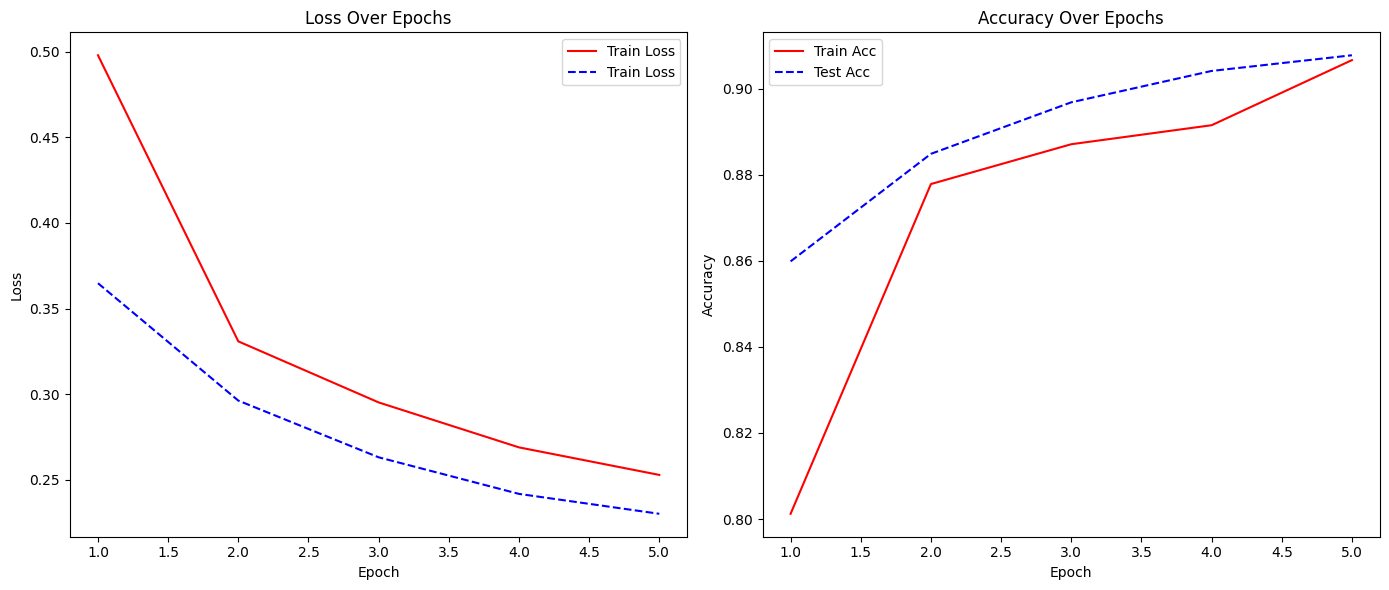

In [119]:
plot_metrics(results)

### Prediction

In [76]:
from typing import List, Union, Tuple

def plot_predictions(model, image_paths, class_names, image_size=(128, 128), device=device, save_path=None):
    model.to(device)
    model.eval()

    # Transform
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths[:12]):
        img = Image.open(img_path).convert("RGB")
        tensor_img = image_transform(img).unsqueeze(0).to(device)

        with torch.inference_mode():
            pred = model(tensor_img)
        
        pred_probs = torch.softmax(pred, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1).item()
        pred_prob = pred_probs[0, pred_label].item()

        axes[i].imshow(img.resize(image_size))
        axes[i].set_title(f"{class_names[pred_label]} ({pred_prob*100:.1f}%)", fontsize=10)
        axes[i].axis("off")

    for j in range(len(image_paths), 12):
        axes[j].axis("off")

    plt.tight_layout()

    if save_path:  # save as PNG
        plt.savefig(save_path, format='png')
    plt.show()

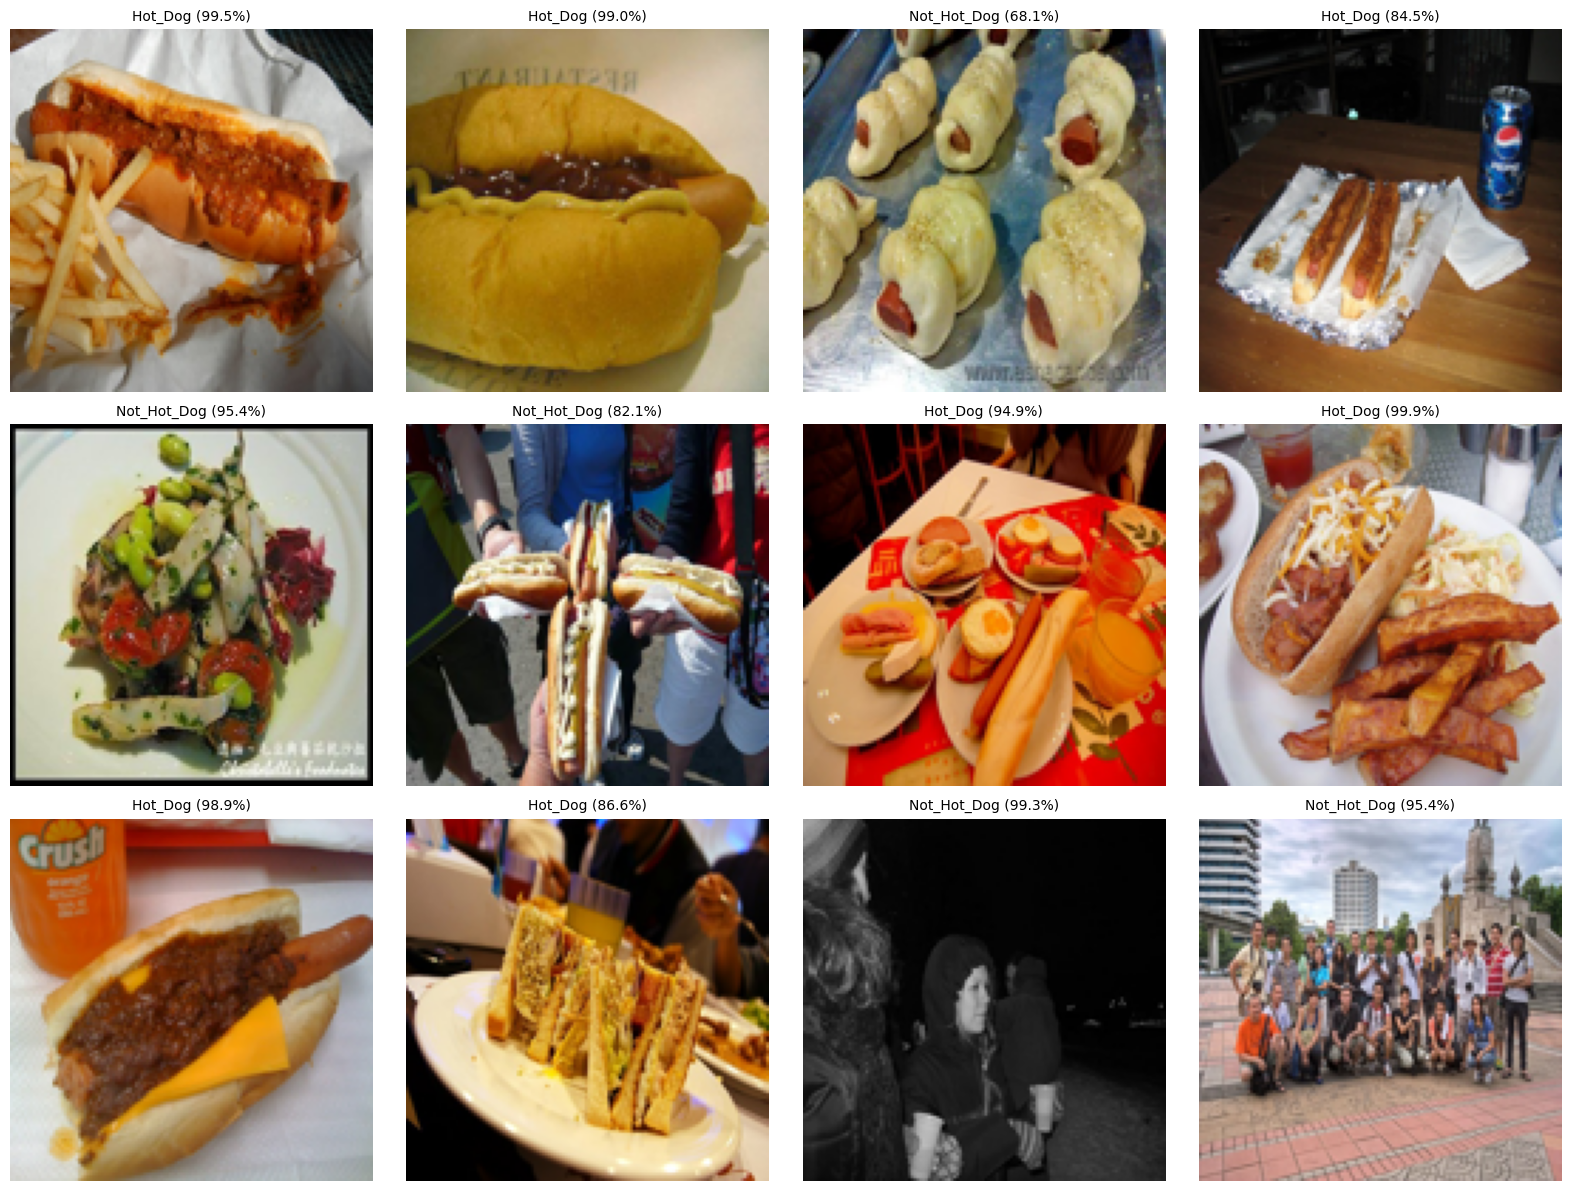

In [77]:
import random
from pathlib import Path

# Path to test dataset
test_dir = Path('../data/hotdog_nothotdog/test')

# Get a list of all images (assuming subfolders for classes)
all_image_paths = list(test_dir.glob("*/*.jpg"))

# Shuffle and select 12 images (or fewer if dataset is small)
num_images_to_plot = 12
selected_images = random.sample(all_image_paths, k=min(num_images_to_plot, len(all_image_paths)))

# Define class names
class_names = ['Hot_Dog', 'Not_Hot_Dog']

plot_predictions(
    model=model,
    image_paths=selected_images,
    class_names=class_names,
    image_size=(128, 128),
    save_path="predictions_figure.png"  # this saves the image
)